In [2]:
from tqdm.auto import tqdm
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import wandb
from torch.utils.data.sampler import SubsetRandomSampler
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit


In [3]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip -O nature_12K.zip
!unzip -q nature_12K.zip

--2025-04-18 20:10:36--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.207, 209.85.145.207, 172.217.214.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G   246MB/s    in 14s     

2025-04-18 20:10:50 (269 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



# Data Processing

In [14]:
# Finding mean and std for normalization


def compute_mean_std(
    dataset_path: str,
    resize: tuple[int, int] = (256, 256),
    batch_size: int = 64,
    num_workers: int = 4
) -> tuple[list[float], list[float]]:
    """
    Returns (mean, std) for each of the 3 channels,
    computed over all images in `dataset_path`.
    """
    # 1) build a loader that only resizes and ToTensor()
    tf = transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor(),   # maps [0..255]→[0..1]
    ])
    ds = datasets.ImageFolder(dataset_path, transform=tf)
    loader = DataLoader(ds, batch_size=batch_size,
                        shuffle=False, num_workers=num_workers)

    # 2) accumulate sum of means & stds
    mean = torch.zeros(3)
    std  = torch.zeros(3)
    n    = 0

    for imgs, _ in loader:
        # imgs shape: [B, 3, H, W] → flatten H×W into one dim
        B, C, H, W = imgs.shape
        pixels = imgs.view(B, C, -1)              # [B,3,H*W]
        mean += pixels.mean(dim=2).sum(dim=0)     # sum of batch means
        std  += pixels.std(dim=2).sum(dim=0)      # sum of batch stds
        n    += B

    mean /= n   # average over all images
    std  /= n
    return mean.tolist(), std.tolist()


# example usage:
train_dir = "inaturalist_12K/train"
mean, std = compute_mean_std(train_dir, resize=(160,160))
print("mean =", mean)
print("std  =", std)


mean = [0.4712284803390503, 0.4600074291229248, 0.3896455466747284]
std  = [0.19014520943164825, 0.18418319523334503, 0.1808110624551773]


In [15]:
def create_dataloaders(
    dataset_path: str,
    num_classes: int = 10,
    data_augmentation: bool = False,
    batch_size: int = 64,
    val_ratio: float = 0.2,
    num_workers: int = 2,
    seed: int = 42,
    resize: tuple[int, int] = (256, 256),
):
    # 1) Mean and standard deviation values calculated from function get_mean_and_std on training dataset
    mean = [0.4712, 0.46, 0.389]
    std  = [0.19, 0.18, 0.18]

    # 2) Build a single train transform (conditional augment) + a test transform
    # ----------------------------------------------------------------------------
    train_ops = [
        transforms.Resize(resize),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
    if data_augmentation:
        # insert augment ops before ToTensor
        aug_ops = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
        ]
        train_ops[0:0] = aug_ops  # prepend aug ops to the pipeline

    train_transform = transforms.Compose(train_ops)

    test_transform = transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    # 3) Load the full train & test datasets once
    train_dir = Path(dataset_path) / "train"
    val_dir   = Path(dataset_path) / "val"

    full_train = datasets.ImageFolder(train_dir, transform=train_transform)
    test_ds    = datasets.ImageFolder(val_dir,   transform=test_transform)

    # 4) Stratified split: ensures each class is represented in train & val
    splitter = StratifiedShuffleSplit(
        n_splits=1,
        test_size=val_ratio,
        random_state=seed
    )
    train_idx, val_idx = next(splitter.split(full_train.samples, full_train.targets))

    train_ds = Subset(full_train, train_idx)

    # For val we want the same Resize+Normalize but no augmentation:
    val_base = datasets.ImageFolder(train_dir, transform=test_transform)
    val_ds   = Subset(val_base, val_idx)

    # 5) DataLoader kwargs for speed
    loader_kwargs = dict(
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
    )

    train_loader = DataLoader(train_ds, shuffle=True,  **loader_kwargs)
    val_loader   = DataLoader(val_ds,   shuffle=False, **loader_kwargs)
    test_loader  = DataLoader(test_ds,  shuffle=False, **loader_kwargs)

    # 6) Return loaders + class names
    return train_loader, val_loader, test_loader, full_train.classes



# Model

In [16]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(
        self,
        num_classes: int,
        num_filters: list[int],
        filter_sizes: list[int],
        activation_fn: nn.Module,
        hid_neurons: int,
        dropout: float = 0.0,
        use_batch_norm: bool = False
    ):
        super(SimpleCNN, self).__init__()
        layers = []
        in_channels = 3 # RGB input

        # Build convolutional feature extractor
        for out_ch, k in zip(num_filters, filter_sizes):
            layers.append(nn.Conv2d(in_channels, out_ch, kernel_size=k, padding=k//2))
            if use_batch_norm:
                layers.append(nn.BatchNorm2d(out_ch))
            layers.append(activation_fn)
            if dropout > 0.0:
                layers.append(nn.Dropout2d(dropout))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_ch

        self.features = nn.Sequential(*layers)
        # Global pooling to flatten spatial dims
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # --- Classification head: flatten → dense → activation → (dropout) → output
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels, hid_neurons),
            activation_fn,
            nn.Dropout(dropout) if dropout > 0.0 else nn.Identity(),
            nn.Linear(hid_neurons, num_classes)
        )

    def forward(self, x):
        x = self.features(x)    # extract convolutional features
        x = self.pool(x)        # global average pooling
        x = self.classifier(x)  # classification MLP
        return x


# train & val

In [19]:

# 1) Helper: one epoch of training
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()    # set model to training mode
    total_loss, correct, count = 0.0, 0, 0

    for imgs, labels in tqdm(loader, desc="  ▶ Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()             # reset gradients
        outputs = model(imgs)             # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward()                   # backpropagate
        optimizer.step()                  # update weights
        
        # accumulate stats
        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        count   += imgs.size(0)
    # compute average loss and accuracy
    avg_loss = total_loss / count
    accuracy = correct / count * 100
    return avg_loss, accuracy

# 2) Helper: one epoch of validation
def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, count = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="  ▶ Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            count   += imgs.size(0)

    avg_loss = total_loss / count
    accuracy = correct / count * 100
    return avg_loss, accuracy

#main training function
def train_model(
    learning_rate:    float,
    num_filters:      list,
    filter_sizes:     list,
    activation_fn:    str,
    optimiser_fn:     str,
    num_neurons_dense:int,
    weight_decay:     float,
    dropout:          float,
    useBatchNorm:     bool,
    batchSize:        int,
    num_epochs:       int,
    augment: bool
):
    # a) device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(device)

    # b) data loaders (stratified 80/20 split + test)
    train_loader, val_loader, test_loader, num_classes = create_dataloaders("inaturalist_12K/", num_classes=10, data_augmentation=augment, batch_size=batchSize)


    # d) build model
    activation_dict = {
        "relu":       nn.ReLU(),
        "gelu":       nn.GELU(),
        "elu" : nn.ELU(),
        "mish":       nn.Mish()
    }


    model = SimpleCNN(
        num_classes =10,
        num_filters        = num_filters,
        filter_sizes       = filter_sizes,
        activation_fn      = activation_dict[activation_fn],
        hid_neurons  = num_neurons_dense,
        dropout       = dropout,
        use_batch_norm     = useBatchNorm
    ).to(device)
    model = nn.DataParallel(model)

    # e) loss + optimizer
    loss_fn = nn.CrossEntropyLoss()



    opt_factory = {
        "adam":   lambda: optim.Adam(model.parameters(),   lr=learning_rate, weight_decay=weight_decay),
        "nadam":  lambda: optim.NAdam(model.parameters(),  lr=learning_rate, weight_decay=weight_decay),
        "rmsprop":lambda: optim.RMSprop(model.parameters(),lr=learning_rate, weight_decay=weight_decay),
        "sgd":    lambda: optim.SGD(model.parameters(),    lr=learning_rate, weight_decay=weight_decay),
    }
    optimizer = opt_factory.get(optimiser_fn.lower(), opt_factory["adam"])()



    # f) training + validation
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss,   val_acc   = validate(      model,   val_loader,   loss_fn, device)

        print(f"  ▶ Train → Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  ▶   Val → Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        # wandb.log({
        #     "epoch":       epoch,
        #     "train_loss":  train_loss,
        #     "train_acc":   train_acc,
        #     "val_loss":    val_loss,
        #     "val_acc":     val_acc
        # })

    # g) final test evaluation
    test_loss, test_acc = validate(model, test_loader, loss_fn, device)
    print(f"\n🎯 Test  → Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")
    #wandb.log({"test_loss": test_loss, "test_acc": test_acc})

    return model



# Best Model Config

In [21]:
model = train_model(
    learning_rate    = 0.0001,
    num_filters       = [128, 128, 64, 64, 32],
    filter_sizes      = [3, 5, 5, 7, 7],
    activation_fn     = "gelu",
    optimiser_fn      = "adam",
    num_neurons_dense = 512,
    weight_decay      = 0.0,
    dropout           = 0.0,
    useBatchNorm      = True,
    batchSize         = 64,
    num_epochs        = 20,
    augment= True
)


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1669, Acc: 22.74%
  ▶   Val → Loss: 2.0925, Acc: 24.95%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0718, Acc: 25.74%
  ▶   Val → Loss: 2.0442, Acc: 27.50%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0187, Acc: 27.95%
  ▶   Val → Loss: 2.0065, Acc: 27.60%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9770, Acc: 29.47%
  ▶   Val → Loss: 1.9691, Acc: 31.60%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9377, Acc: 31.30%
  ▶   Val → Loss: 1.8958, Acc: 32.30%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9039, Acc: 32.73%
  ▶   Val → Loss: 1.8887, Acc: 32.70%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8709, Acc: 33.70%
  ▶   Val → Loss: 1.9428, Acc: 32.95%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8474, Acc: 34.72%
  ▶   Val → Loss: 1.8058, Acc: 36.60%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8084, Acc: 35.93%
  ▶   Val → Loss: 1.8575, Acc: 35.40%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7982, Acc: 36.72%
  ▶   Val → Loss: 1.7825, Acc: 38.15%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7722, Acc: 36.90%
  ▶   Val → Loss: 1.7710, Acc: 38.85%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7617, Acc: 38.17%
  ▶   Val → Loss: 1.8089, Acc: 36.70%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7287, Acc: 38.63%
  ▶   Val → Loss: 1.7679, Acc: 39.45%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7243, Acc: 39.39%
  ▶   Val → Loss: 1.8474, Acc: 36.90%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6988, Acc: 40.83%
  ▶   Val → Loss: 1.7224, Acc: 39.95%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6913, Acc: 40.83%
  ▶   Val → Loss: 1.7826, Acc: 37.95%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6598, Acc: 41.77%
  ▶   Val → Loss: 1.7542, Acc: 39.50%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6520, Acc: 42.03%
  ▶   Val → Loss: 1.7039, Acc: 40.65%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6377, Acc: 43.24%
  ▶   Val → Loss: 1.6735, Acc: 41.15%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6171, Acc: 43.12%
  ▶   Val → Loss: 1.6592, Acc: 41.80%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.6798, Acc: 41.60%


# 10 x 3 img predict & confusion matrix

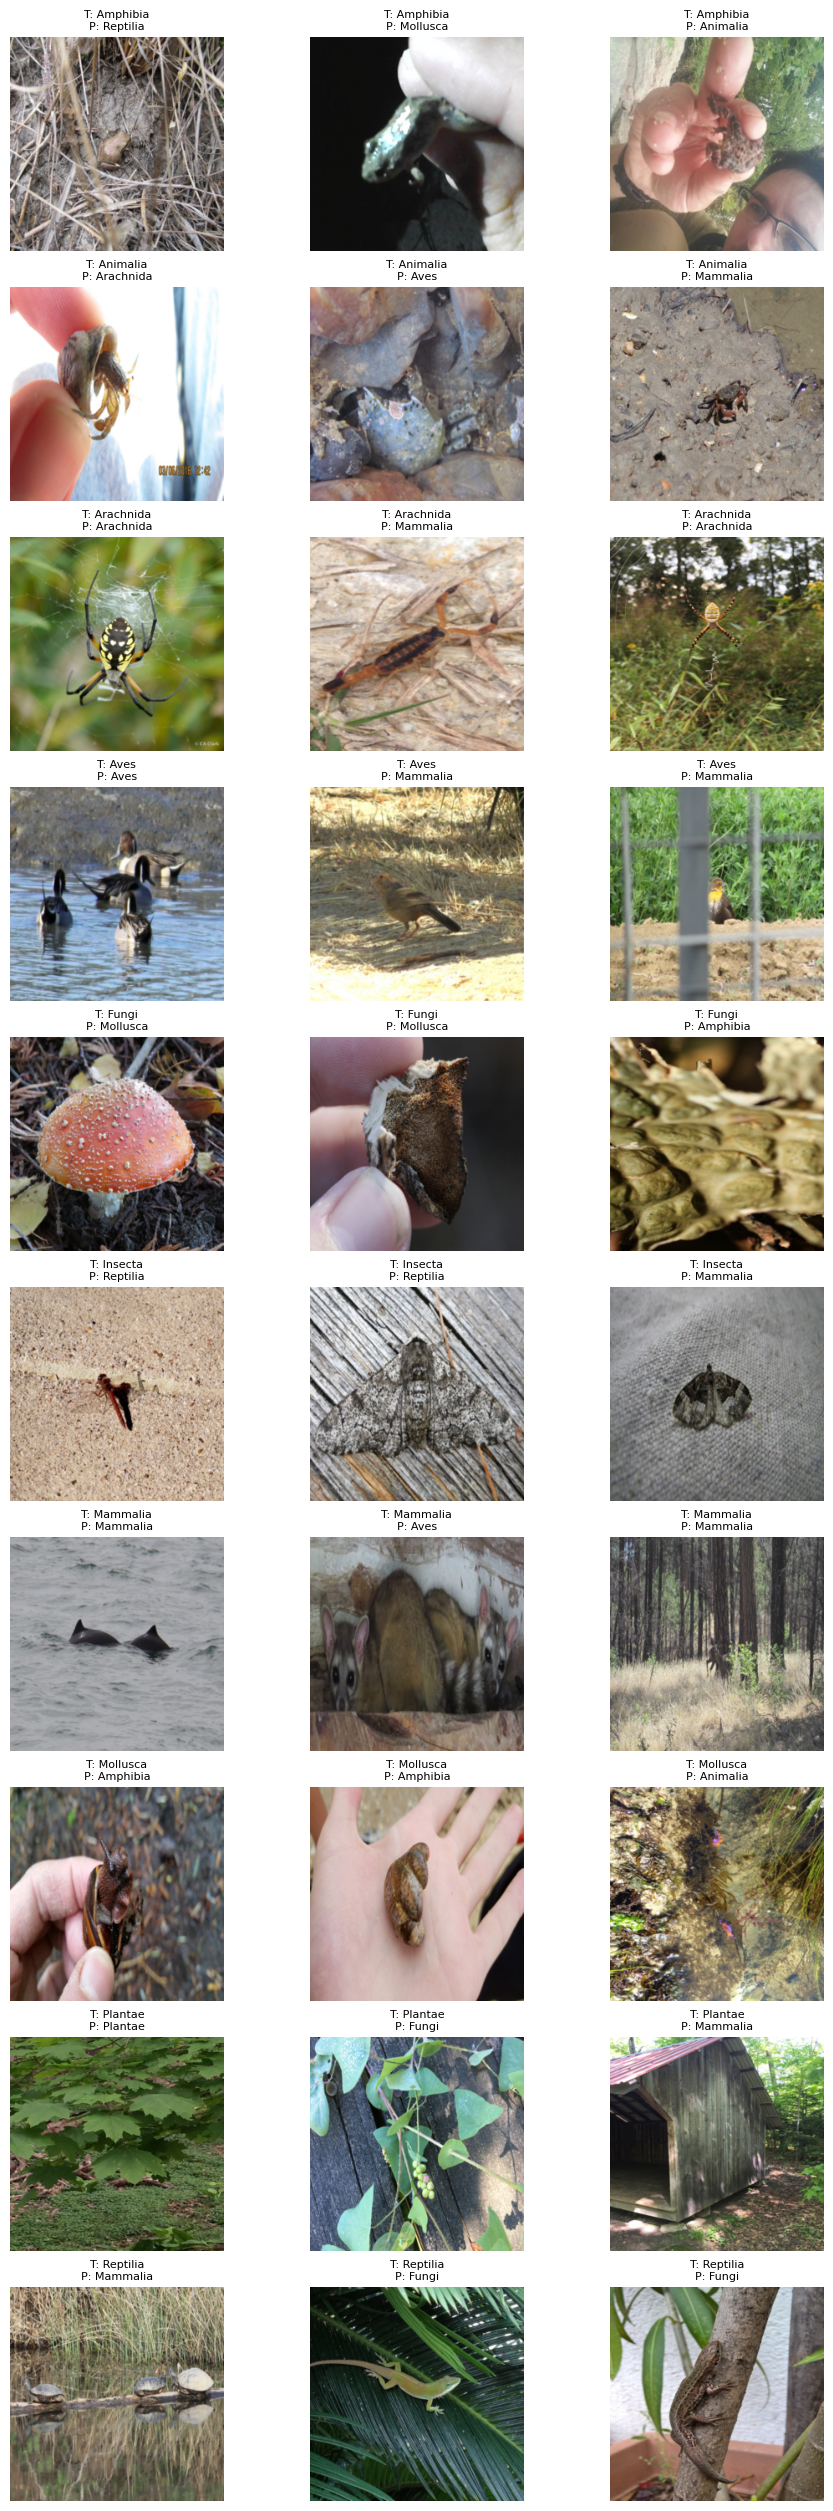

In [40]:
train_loader, val_loader, test_loader, num_classes = create_dataloaders(
    "inaturalist_12K/",
    num_classes=10,
    data_augmentation=True,
    batch_size=64
)
class_names = [
    "Amphibia", "Animalia", "Arachnida", "Aves", "Fungi",
    "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt

def plot_test_grid(model, test_loader, class_names, device, samples_per_class=3):
    """
    Plots a grid of samples_per_class images for each class from test_loader,
    with both true and predicted labels shown.
    """
    model.eval()
    # collect up to samples_per_class images per true class
    collected = {i: [] for i in range(len(class_names))}

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            for img, true_lbl, pred_lbl in zip(imgs, labels, preds):
                cls = true_lbl.item()
                if len(collected[cls]) < samples_per_class:
                    # store image tensor + true & predicted indices
                    collected[cls].append((img.cpu(), true_lbl.item(), pred_lbl.item()))
            if all(len(collected[c]) >= samples_per_class for c in collected):
                break

    # set up the grid
    n_rows = len(class_names)
    n_cols = samples_per_class
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 3, n_rows * 2.5),
        constrained_layout=True
    )

    # denormalization stats (same as training transforms)
    mean = torch.tensor([0.4712, 0.46, 0.389])[:, None, None]
    std  = torch.tensor([0.19, 0.18, 0.18])[:, None, None]

    for row in range(n_rows):
        for col in range(n_cols):
            ax = axes[row, col]
            img, true_lbl, pred_lbl = collected[row][col]
            # undo normalization, convert to H×W×C
            img = img * std + mean
            img = img.clamp(0, 1).permute(1, 2, 0).numpy()

            ax.imshow(img)
            ax.axis('off')
            ax.set_title(
                f"T: {class_names[true_lbl]}\nP: {class_names[pred_lbl]}",
                fontsize=8
            )

        # label the left side of each row with the true class
        axes[row, 0].set_ylabel(
            class_names[row],
            rotation=0,
            labelpad=40,
            va='center'
        )

    
    plt.savefig('/kaggle/working/img-10x3_2.png', dpi=100)  
    plt.show()
    return fig


fig = plot_test_grid(model, test_loader, class_names, device)


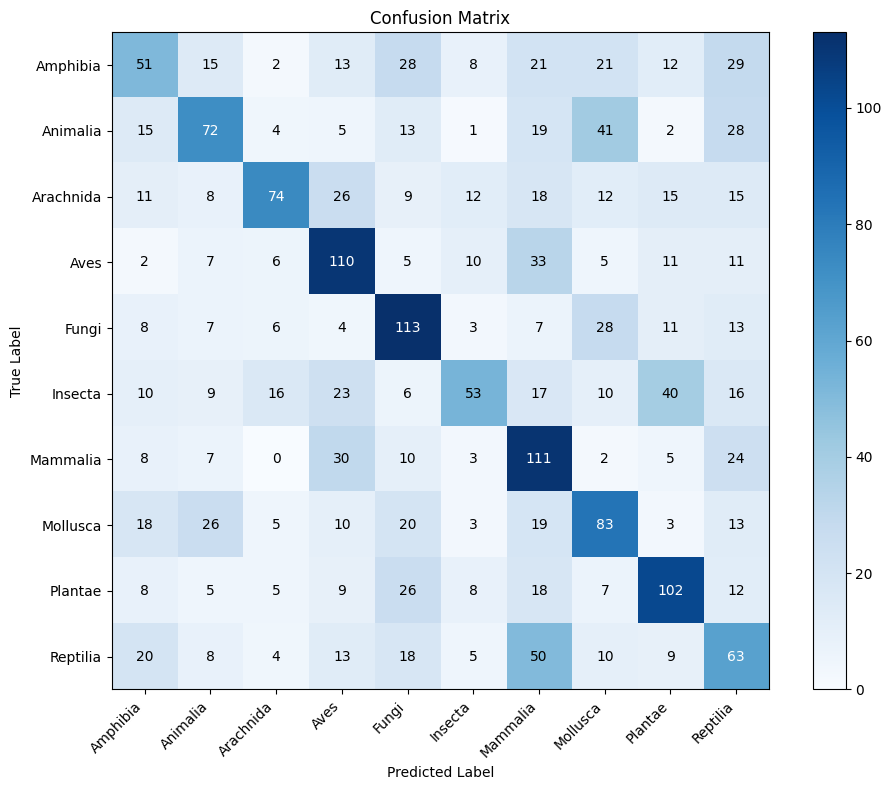

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import wandb
from sklearn.metrics import confusion_matrix

def plot_and_log_confusion_matrix(model, loader, class_names, device, normalize: bool = False):
    """
    Computes and plots the confusion matrix for `model` on `loader`, then logs it to W&B.
    
    Args:
        model       : trained PyTorch model
        loader      : DataLoader for test set
        class_names : list of class-name strings
        device      : torch.device
        normalize   : if True, plot normalized CM (proportions), else raw counts
    Returns:
        fig         : the matplotlib Figure object
    """
    model.eval()
    all_preds = []
    all_labels = []

    # 1) Gather predictions and true labels
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 2) Compute confusion matrix
    cm = confusion_matrix(
        all_labels,
        all_preds,
        labels=range(len(class_names)),
        normalize='true' if normalize else None
    )

    # 3) Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar(im, ax=ax)

    # Tick marks and labels
    ticks = np.arange(len(class_names))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    # Titles and axis labels
    title = "Normalized Confusion Matrix" if normalize else "Confusion Matrix"
    ax.set_title(title)
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    # Annotate each cell with count or proportion
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.tight_layout()

    plt.savefig('/kaggle/working/confusion-mat.png', dpi=200)  
    plt.show()

    return fig
    
# after training and having your best_model in scope
fig_cm = plot_and_log_confusion_matrix(
    model=model,
    loader=test_loader,
    class_names=class_names,
    device=device,
    normalize=False  # or True for proportions
)


# wandb sweep after shortlist 

In [12]:
sweep_config = {
    'method': 'bayes',
    'name' : '20-epoch-final',
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'
    },
    'parameters': {
        'num_filters': {
          'values': [[128,128,64,64,32],[16,32,64,128,256]]
        },
        'filter_sizes': {
          'values': [[3,3,3,3,3], [3,5,5,7,7]]
        },
        'weight_decay': {
            'value': 0
        },
        'dropout': {
            'value': 0
        },
        'learning_rate': {
            'values': [1e-4, 1e-3]
        },
        'activation': {
            'values': ['gelu', 'relu']
        },
        'optimiser': {
            'values': ['nadam', 'adam']
        },
        'batch_norm':{
            'value': True
        },
        'augment' : {
             'value': True
        },
        'batch_size': {
            'value': 64
        },
        'dense_layer':{
            'values': [ 256, 512]
        }
    }
}



def main():
    wandb.init(project="Assignment 2")
    config = wandb.config

    run_name = f"opt={config.optimiser}_act={config.activation}_nfilt={config.num_filters}_bs={config.batch_size}_layer={config.dense_layer}_dropout={config.dropout}_augment={config.augment}_norm={config.batch_norm}_lr={config.learning_rate}_"

    # Set the run name
    wandb.run.name = run_name
    wandb.run.save()


    # train model
    train_model(learning_rate = config.learning_rate,
                num_filters = config.num_filters,
                filter_sizes = config.filter_sizes,
                activation_fn = config.activation,
                optimiser_fn = config.optimiser,
                num_neurons_dense = config.dense_layer,
                weight_decay = config.weight_decay,
                dropout = config.dropout,
                useBatchNorm = config.batch_norm,
                batchSize = config.batch_size,
                num_epochs = 20,
                augment=config.augment)



sweep_id=wandb.sweep(sweep_config, entity="cs24m033-iit-madras", project="DA6401-A2")
wandb.agent(sweep_id, function= main, count=20)
wandb.finish()

Create sweep with ID: s9xnwrst
Sweep URL: https://wandb.ai/cs24m033-iit-madras/DA6401-A2/sweeps/s9xnwrst


wandb: Agent Starting Run: d221mbnk with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1542, Acc: 21.85%
  ▶   Val → Loss: 2.0715, Acc: 25.60%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0699, Acc: 25.52%
  ▶   Val → Loss: 2.0410, Acc: 27.50%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0305, Acc: 27.53%
  ▶   Val → Loss: 2.0357, Acc: 27.35%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0028, Acc: 28.38%
  ▶   Val → Loss: 2.0902, Acc: 25.85%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9878, Acc: 28.38%
  ▶   Val → Loss: 1.9862, Acc: 29.15%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9577, Acc: 30.19%
  ▶   Val → Loss: 1.9764, Acc: 29.15%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9320, Acc: 30.54%
  ▶   Val → Loss: 1.9577, Acc: 30.20%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9070, Acc: 31.79%
  ▶   Val → Loss: 1.9491, Acc: 31.25%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8795, Acc: 33.20%
  ▶   Val → Loss: 1.9354, Acc: 32.55%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8514, Acc: 33.60%
  ▶   Val → Loss: 1.8654, Acc: 35.30%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8442, Acc: 34.47%
  ▶   Val → Loss: 1.8672, Acc: 34.90%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8135, Acc: 35.85%
  ▶   Val → Loss: 1.8799, Acc: 35.05%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7946, Acc: 36.54%
  ▶   Val → Loss: 1.8881, Acc: 34.05%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7688, Acc: 36.88%
  ▶   Val → Loss: 1.7657, Acc: 38.10%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7554, Acc: 37.58%
  ▶   Val → Loss: 1.9476, Acc: 33.05%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7283, Acc: 39.20%
  ▶   Val → Loss: 1.7926, Acc: 38.50%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7099, Acc: 39.02%
  ▶   Val → Loss: 1.7845, Acc: 37.10%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6871, Acc: 41.12%
  ▶   Val → Loss: 1.7651, Acc: 39.30%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6638, Acc: 41.43%
  ▶   Val → Loss: 1.6834, Acc: 42.45%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6430, Acc: 41.96%
  ▶   Val → Loss: 1.7084, Acc: 41.65%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7244, Acc: 40.10%


wandb: Agent Starting Run: hfh0dr2d with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 512
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1429, Acc: 22.20%
  ▶   Val → Loss: 2.1164, Acc: 24.75%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0653, Acc: 25.49%
  ▶   Val → Loss: 2.0729, Acc: 26.90%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0359, Acc: 26.85%
  ▶   Val → Loss: 2.0955, Acc: 27.15%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9853, Acc: 29.33%
  ▶   Val → Loss: 1.9783, Acc: 30.90%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9577, Acc: 29.57%
  ▶   Val → Loss: 2.1098, Acc: 28.05%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9162, Acc: 31.39%
  ▶   Val → Loss: 1.9367, Acc: 30.60%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8856, Acc: 32.19%
  ▶   Val → Loss: 1.9939, Acc: 29.05%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8734, Acc: 32.84%
  ▶   Val → Loss: 1.8941, Acc: 32.35%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8324, Acc: 34.47%
  ▶   Val → Loss: 1.9187, Acc: 32.15%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8066, Acc: 35.68%
  ▶   Val → Loss: 1.8508, Acc: 34.70%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7880, Acc: 35.63%
  ▶   Val → Loss: 1.9583, Acc: 33.40%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7573, Acc: 36.92%
  ▶   Val → Loss: 1.8459, Acc: 35.20%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7487, Acc: 37.60%
  ▶   Val → Loss: 1.7911, Acc: 37.20%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7334, Acc: 38.52%
  ▶   Val → Loss: 1.8013, Acc: 35.65%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7078, Acc: 39.37%
  ▶   Val → Loss: 1.8067, Acc: 37.15%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6964, Acc: 38.60%
  ▶   Val → Loss: 1.7539, Acc: 38.55%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6784, Acc: 40.86%
  ▶   Val → Loss: 1.7170, Acc: 39.25%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6480, Acc: 41.03%
  ▶   Val → Loss: 1.7502, Acc: 39.35%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6393, Acc: 42.37%
  ▶   Val → Loss: 1.7690, Acc: 38.55%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6146, Acc: 42.68%
  ▶   Val → Loss: 1.7857, Acc: 37.80%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7915, Acc: 38.50%


wandb: Agent Starting Run: 9et33tqx with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 512
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 3, 3, 3, 3]
wandb: 	learning_rate: 0.001
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1113, Acc: 23.34%
  ▶   Val → Loss: 2.1043, Acc: 25.40%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0241, Acc: 27.23%
  ▶   Val → Loss: 2.3470, Acc: 23.60%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9753, Acc: 29.12%
  ▶   Val → Loss: 2.0337, Acc: 27.75%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9427, Acc: 29.90%
  ▶   Val → Loss: 1.9170, Acc: 32.10%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9018, Acc: 31.77%
  ▶   Val → Loss: 1.9358, Acc: 31.25%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8705, Acc: 33.15%
  ▶   Val → Loss: 1.9355, Acc: 31.00%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8478, Acc: 33.97%
  ▶   Val → Loss: 1.8727, Acc: 33.80%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8126, Acc: 35.47%
  ▶   Val → Loss: 1.8620, Acc: 35.95%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7939, Acc: 35.78%
  ▶   Val → Loss: 1.8194, Acc: 37.70%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7783, Acc: 36.67%
  ▶   Val → Loss: 1.8746, Acc: 34.25%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7549, Acc: 36.92%
  ▶   Val → Loss: 1.8764, Acc: 33.55%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7336, Acc: 38.62%
  ▶   Val → Loss: 1.8189, Acc: 38.05%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7123, Acc: 39.05%
  ▶   Val → Loss: 1.7932, Acc: 38.15%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6979, Acc: 39.33%
  ▶   Val → Loss: 1.7948, Acc: 37.30%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6767, Acc: 40.43%
  ▶   Val → Loss: 1.7758, Acc: 37.05%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6644, Acc: 40.74%
  ▶   Val → Loss: 1.8769, Acc: 35.20%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6411, Acc: 41.54%
  ▶   Val → Loss: 1.8307, Acc: 38.40%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6303, Acc: 42.07%
  ▶   Val → Loss: 1.8622, Acc: 37.65%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6148, Acc: 43.39%
  ▶   Val → Loss: 2.0261, Acc: 35.35%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.5936, Acc: 43.42%
  ▶   Val → Loss: 1.8581, Acc: 36.80%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.8516, Acc: 37.80%


wandb: Agent Starting Run: cwexqbbc with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 512
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1618, Acc: 20.63%
  ▶   Val → Loss: 2.1347, Acc: 23.25%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0777, Acc: 25.08%
  ▶   Val → Loss: 2.0840, Acc: 26.95%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0383, Acc: 27.30%
  ▶   Val → Loss: 2.0102, Acc: 28.15%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0105, Acc: 27.50%
  ▶   Val → Loss: 1.9963, Acc: 29.20%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9719, Acc: 29.62%
  ▶   Val → Loss: 2.0303, Acc: 28.70%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9579, Acc: 29.38%
  ▶   Val → Loss: 1.9619, Acc: 30.40%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9277, Acc: 30.68%
  ▶   Val → Loss: 1.9537, Acc: 30.60%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8956, Acc: 32.14%
  ▶   Val → Loss: 1.9190, Acc: 32.60%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8756, Acc: 32.85%
  ▶   Val → Loss: 1.8974, Acc: 31.95%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8702, Acc: 33.33%
  ▶   Val → Loss: 1.9793, Acc: 31.20%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8454, Acc: 33.85%
  ▶   Val → Loss: 1.8280, Acc: 35.20%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8212, Acc: 35.33%
  ▶   Val → Loss: 1.8756, Acc: 34.30%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8088, Acc: 35.45%
  ▶   Val → Loss: 1.8424, Acc: 35.45%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7981, Acc: 36.03%
  ▶   Val → Loss: 1.8428, Acc: 35.00%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7654, Acc: 37.42%
  ▶   Val → Loss: 1.8463, Acc: 36.30%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7346, Acc: 38.72%
  ▶   Val → Loss: 1.7650, Acc: 38.15%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7284, Acc: 38.63%
  ▶   Val → Loss: 1.7888, Acc: 38.75%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7058, Acc: 39.47%
  ▶   Val → Loss: 1.7779, Acc: 38.75%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6917, Acc: 40.59%
  ▶   Val → Loss: 1.8702, Acc: 34.60%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6641, Acc: 42.01%
  ▶   Val → Loss: 1.7661, Acc: 38.25%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7646, Acc: 40.25%


wandb: Agent Starting Run: luxxhot2 with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1563, Acc: 21.83%
  ▶   Val → Loss: 2.0990, Acc: 24.50%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0670, Acc: 25.63%
  ▶   Val → Loss: 2.1038, Acc: 26.50%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0253, Acc: 27.37%
  ▶   Val → Loss: 2.0007, Acc: 27.35%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9985, Acc: 28.03%
  ▶   Val → Loss: 2.0007, Acc: 30.00%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9664, Acc: 29.55%
  ▶   Val → Loss: 2.0135, Acc: 29.50%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9495, Acc: 29.78%
  ▶   Val → Loss: 1.9698, Acc: 30.10%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9228, Acc: 31.24%
  ▶   Val → Loss: 1.9447, Acc: 31.50%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9054, Acc: 32.10%
  ▶   Val → Loss: 1.9070, Acc: 32.80%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8878, Acc: 32.75%
  ▶   Val → Loss: 1.9523, Acc: 31.95%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8620, Acc: 34.40%
  ▶   Val → Loss: 1.9436, Acc: 32.55%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8462, Acc: 34.09%
  ▶   Val → Loss: 1.9179, Acc: 32.75%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8114, Acc: 35.00%
  ▶   Val → Loss: 1.8515, Acc: 34.70%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7936, Acc: 35.98%
  ▶   Val → Loss: 1.8930, Acc: 33.80%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7794, Acc: 36.80%
  ▶   Val → Loss: 2.0264, Acc: 31.45%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7640, Acc: 37.85%
  ▶   Val → Loss: 1.8819, Acc: 35.45%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7316, Acc: 38.57%
  ▶   Val → Loss: 1.8068, Acc: 37.65%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7359, Acc: 38.04%
  ▶   Val → Loss: 1.7611, Acc: 39.65%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7037, Acc: 39.74%
  ▶   Val → Loss: 1.8147, Acc: 37.70%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6895, Acc: 40.28%
  ▶   Val → Loss: 1.7621, Acc: 40.05%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6702, Acc: 40.71%
  ▶   Val → Loss: 1.7412, Acc: 38.45%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7370, Acc: 40.25%


wandb: Agent Starting Run: ab344s6z with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1951, Acc: 22.88%
  ▶   Val → Loss: 2.1356, Acc: 24.40%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1030, Acc: 26.00%
  ▶   Val → Loss: 2.0950, Acc: 25.30%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0497, Acc: 26.98%
  ▶   Val → Loss: 2.0524, Acc: 27.05%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0048, Acc: 28.72%
  ▶   Val → Loss: 1.9961, Acc: 28.30%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9699, Acc: 29.85%
  ▶   Val → Loss: 1.9612, Acc: 30.05%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9406, Acc: 30.92%
  ▶   Val → Loss: 1.9174, Acc: 33.00%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9097, Acc: 32.34%
  ▶   Val → Loss: 1.9242, Acc: 31.50%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8805, Acc: 33.64%
  ▶   Val → Loss: 1.9049, Acc: 32.75%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8565, Acc: 34.20%
  ▶   Val → Loss: 1.8918, Acc: 33.25%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8316, Acc: 35.47%
  ▶   Val → Loss: 1.8425, Acc: 35.65%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8119, Acc: 36.07%
  ▶   Val → Loss: 1.8022, Acc: 37.45%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7799, Acc: 36.95%
  ▶   Val → Loss: 1.8194, Acc: 37.10%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7632, Acc: 37.92%
  ▶   Val → Loss: 1.7753, Acc: 37.55%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7468, Acc: 38.27%
  ▶   Val → Loss: 1.8291, Acc: 35.05%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7287, Acc: 39.63%
  ▶   Val → Loss: 1.8178, Acc: 35.70%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7146, Acc: 39.92%
  ▶   Val → Loss: 1.7381, Acc: 40.40%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7094, Acc: 40.32%
  ▶   Val → Loss: 1.7098, Acc: 39.60%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6905, Acc: 40.43%
  ▶   Val → Loss: 1.7086, Acc: 41.15%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6764, Acc: 41.24%
  ▶   Val → Loss: 1.7019, Acc: 40.30%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6633, Acc: 41.44%
  ▶   Val → Loss: 1.6803, Acc: 41.90%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.6833, Acc: 40.35%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jqkv2bpy with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1853, Acc: 21.69%
  ▶   Val → Loss: 2.1327, Acc: 23.00%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1006, Acc: 25.33%
  ▶   Val → Loss: 2.0667, Acc: 26.40%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0409, Acc: 26.80%
  ▶   Val → Loss: 2.0130, Acc: 27.45%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9981, Acc: 29.02%
  ▶   Val → Loss: 2.0103, Acc: 27.95%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9599, Acc: 30.43%
  ▶   Val → Loss: 1.9559, Acc: 30.45%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9288, Acc: 31.10%
  ▶   Val → Loss: 1.9422, Acc: 31.90%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9019, Acc: 32.29%
  ▶   Val → Loss: 1.8834, Acc: 32.05%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8796, Acc: 32.50%
  ▶   Val → Loss: 1.8619, Acc: 34.60%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8502, Acc: 34.73%
  ▶   Val → Loss: 1.8382, Acc: 36.40%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8310, Acc: 35.33%
  ▶   Val → Loss: 1.8364, Acc: 34.95%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8235, Acc: 35.52%
  ▶   Val → Loss: 1.8236, Acc: 37.80%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7934, Acc: 36.68%
  ▶   Val → Loss: 1.8048, Acc: 36.95%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7769, Acc: 36.94%
  ▶   Val → Loss: 1.7843, Acc: 38.45%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7708, Acc: 37.84%
  ▶   Val → Loss: 1.7813, Acc: 37.65%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7510, Acc: 38.33%
  ▶   Val → Loss: 1.7629, Acc: 40.65%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7339, Acc: 38.99%
  ▶   Val → Loss: 1.7761, Acc: 38.50%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7285, Acc: 38.77%
  ▶   Val → Loss: 1.7808, Acc: 38.05%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7095, Acc: 39.98%
  ▶   Val → Loss: 1.7581, Acc: 39.65%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6871, Acc: 41.02%
  ▶   Val → Loss: 1.7128, Acc: 41.40%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6711, Acc: 41.27%
  ▶   Val → Loss: 1.7677, Acc: 38.85%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7778, Acc: 38.50%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oho1t5cw with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1742, Acc: 23.32%
  ▶   Val → Loss: 2.1178, Acc: 26.20%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0876, Acc: 26.45%
  ▶   Val → Loss: 2.0618, Acc: 27.70%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0319, Acc: 27.83%
  ▶   Val → Loss: 2.0599, Acc: 25.60%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9949, Acc: 28.68%
  ▶   Val → Loss: 2.0028, Acc: 29.55%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9588, Acc: 31.37%
  ▶   Val → Loss: 1.9440, Acc: 31.30%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9338, Acc: 31.44%
  ▶   Val → Loss: 1.9305, Acc: 32.30%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9059, Acc: 32.57%
  ▶   Val → Loss: 1.9081, Acc: 33.70%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8702, Acc: 34.34%
  ▶   Val → Loss: 1.8597, Acc: 35.55%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8497, Acc: 34.95%
  ▶   Val → Loss: 1.8566, Acc: 35.30%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8254, Acc: 35.64%
  ▶   Val → Loss: 1.8299, Acc: 35.90%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8015, Acc: 36.40%
  ▶   Val → Loss: 1.8458, Acc: 35.55%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7868, Acc: 36.72%
  ▶   Val → Loss: 1.7927, Acc: 36.05%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7708, Acc: 38.02%
  ▶   Val → Loss: 1.8440, Acc: 36.90%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7594, Acc: 37.68%
  ▶   Val → Loss: 1.7938, Acc: 38.10%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7385, Acc: 38.97%
  ▶   Val → Loss: 1.8174, Acc: 37.30%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7253, Acc: 39.04%
  ▶   Val → Loss: 1.8960, Acc: 34.80%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7010, Acc: 40.21%
  ▶   Val → Loss: 1.7291, Acc: 40.60%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6970, Acc: 40.17%
  ▶   Val → Loss: 1.7736, Acc: 37.00%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6846, Acc: 41.18%
  ▶   Val → Loss: 1.7403, Acc: 39.65%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6655, Acc: 41.94%
  ▶   Val → Loss: 1.7068, Acc: 41.40%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7127, Acc: 42.00%


wandb: Agent Starting Run: h8p7d2mc with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1820, Acc: 21.85%
  ▶   Val → Loss: 2.1208, Acc: 25.60%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0868, Acc: 26.38%
  ▶   Val → Loss: 2.0619, Acc: 27.15%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0242, Acc: 27.78%
  ▶   Val → Loss: 2.0340, Acc: 27.90%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9879, Acc: 29.38%
  ▶   Val → Loss: 2.0113, Acc: 27.35%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9441, Acc: 31.27%
  ▶   Val → Loss: 1.9847, Acc: 29.10%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9180, Acc: 31.67%
  ▶   Val → Loss: 1.9161, Acc: 33.05%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8892, Acc: 32.47%
  ▶   Val → Loss: 1.8984, Acc: 33.00%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8658, Acc: 33.77%
  ▶   Val → Loss: 1.8901, Acc: 33.30%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8445, Acc: 34.44%
  ▶   Val → Loss: 1.8872, Acc: 34.50%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8161, Acc: 35.80%
  ▶   Val → Loss: 1.8820, Acc: 34.55%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8008, Acc: 36.49%
  ▶   Val → Loss: 1.8344, Acc: 35.80%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7731, Acc: 37.89%
  ▶   Val → Loss: 1.8078, Acc: 37.25%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7572, Acc: 38.09%
  ▶   Val → Loss: 1.7552, Acc: 40.85%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7396, Acc: 39.04%
  ▶   Val → Loss: 1.8828, Acc: 35.75%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7218, Acc: 39.68%
  ▶   Val → Loss: 1.7443, Acc: 36.95%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7190, Acc: 39.50%
  ▶   Val → Loss: 1.7031, Acc: 42.10%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6959, Acc: 40.51%
  ▶   Val → Loss: 1.7390, Acc: 38.50%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6882, Acc: 40.46%
  ▶   Val → Loss: 1.7036, Acc: 41.50%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6614, Acc: 42.28%
  ▶   Val → Loss: 1.6889, Acc: 40.85%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6467, Acc: 42.38%
  ▶   Val → Loss: 1.7379, Acc: 38.50%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7399, Acc: 39.10%


wandb: Agent Starting Run: 400pwhmt with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1787, Acc: 22.84%
  ▶   Val → Loss: 2.1006, Acc: 26.20%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0954, Acc: 25.45%
  ▶   Val → Loss: 2.0953, Acc: 26.55%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0343, Acc: 28.07%
  ▶   Val → Loss: 2.0577, Acc: 27.35%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9898, Acc: 29.04%
  ▶   Val → Loss: 1.9629, Acc: 31.20%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9442, Acc: 31.52%
  ▶   Val → Loss: 1.9566, Acc: 30.35%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9064, Acc: 33.07%
  ▶   Val → Loss: 1.8684, Acc: 35.25%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8867, Acc: 33.08%
  ▶   Val → Loss: 1.9471, Acc: 31.95%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8463, Acc: 35.15%
  ▶   Val → Loss: 1.8293, Acc: 37.80%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8312, Acc: 35.59%
  ▶   Val → Loss: 1.8230, Acc: 36.80%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8018, Acc: 36.79%
  ▶   Val → Loss: 1.7983, Acc: 38.25%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7776, Acc: 36.89%
  ▶   Val → Loss: 1.7769, Acc: 38.15%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7722, Acc: 37.47%
  ▶   Val → Loss: 1.8406, Acc: 35.85%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7500, Acc: 38.50%
  ▶   Val → Loss: 1.7230, Acc: 40.25%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7204, Acc: 39.09%
  ▶   Val → Loss: 1.8692, Acc: 34.80%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7083, Acc: 39.73%
  ▶   Val → Loss: 1.7536, Acc: 39.75%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6885, Acc: 40.91%
  ▶   Val → Loss: 1.7154, Acc: 41.45%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6809, Acc: 40.33%
  ▶   Val → Loss: 1.7450, Acc: 39.90%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6621, Acc: 41.48%
  ▶   Val → Loss: 1.7345, Acc: 39.95%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6404, Acc: 42.57%
  ▶   Val → Loss: 1.7258, Acc: 39.25%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6308, Acc: 42.73%
  ▶   Val → Loss: 1.6552, Acc: 42.75%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.6721, Acc: 42.20%


wandb: Agent Starting Run: 56mdg103 with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1507, Acc: 22.60%
  ▶   Val → Loss: 2.0676, Acc: 26.55%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0670, Acc: 26.13%
  ▶   Val → Loss: 2.0318, Acc: 28.25%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0209, Acc: 27.58%
  ▶   Val → Loss: 2.0416, Acc: 28.05%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9907, Acc: 29.23%
  ▶   Val → Loss: 1.9950, Acc: 29.80%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9580, Acc: 29.45%
  ▶   Val → Loss: 1.9622, Acc: 30.00%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9218, Acc: 31.69%
  ▶   Val → Loss: 1.8955, Acc: 32.60%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9010, Acc: 32.20%
  ▶   Val → Loss: 2.0350, Acc: 28.15%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8694, Acc: 33.18%
  ▶   Val → Loss: 2.1323, Acc: 30.15%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8425, Acc: 34.90%
  ▶   Val → Loss: 1.8462, Acc: 36.25%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8150, Acc: 35.20%
  ▶   Val → Loss: 1.8700, Acc: 35.00%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7928, Acc: 36.20%
  ▶   Val → Loss: 1.8762, Acc: 35.45%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7728, Acc: 36.87%
  ▶   Val → Loss: 1.7992, Acc: 35.65%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7565, Acc: 38.04%
  ▶   Val → Loss: 1.7606, Acc: 38.90%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7282, Acc: 38.49%
  ▶   Val → Loss: 1.7704, Acc: 39.30%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7191, Acc: 38.99%
  ▶   Val → Loss: 1.8934, Acc: 35.60%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7035, Acc: 39.93%
  ▶   Val → Loss: 1.7394, Acc: 40.05%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6784, Acc: 40.87%
  ▶   Val → Loss: 1.8562, Acc: 36.00%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6530, Acc: 42.03%
  ▶   Val → Loss: 1.8807, Acc: 37.30%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6468, Acc: 42.12%
  ▶   Val → Loss: 1.7286, Acc: 39.00%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6232, Acc: 43.26%
  ▶   Val → Loss: 1.7417, Acc: 40.35%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7437, Acc: 39.80%


wandb: Agent Starting Run: rn10grmr with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1879, Acc: 22.60%
  ▶   Val → Loss: 2.1239, Acc: 23.90%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0999, Acc: 26.18%
  ▶   Val → Loss: 2.0921, Acc: 24.30%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0388, Acc: 27.84%
  ▶   Val → Loss: 2.0075, Acc: 27.55%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9838, Acc: 29.57%
  ▶   Val → Loss: 1.9739, Acc: 31.25%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9530, Acc: 31.32%
  ▶   Val → Loss: 1.9417, Acc: 31.20%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9098, Acc: 33.10%
  ▶   Val → Loss: 1.8960, Acc: 33.75%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8854, Acc: 33.67%
  ▶   Val → Loss: 1.8617, Acc: 34.80%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8561, Acc: 34.12%
  ▶   Val → Loss: 1.8922, Acc: 32.90%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8301, Acc: 34.43%
  ▶   Val → Loss: 1.8301, Acc: 36.45%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8109, Acc: 35.59%
  ▶   Val → Loss: 1.8178, Acc: 37.50%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7819, Acc: 37.28%
  ▶   Val → Loss: 1.9042, Acc: 33.90%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7712, Acc: 37.34%
  ▶   Val → Loss: 1.8610, Acc: 34.60%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7537, Acc: 37.79%
  ▶   Val → Loss: 1.7495, Acc: 39.55%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7331, Acc: 38.67%
  ▶   Val → Loss: 1.7796, Acc: 37.65%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7158, Acc: 39.50%
  ▶   Val → Loss: 1.7473, Acc: 38.75%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7055, Acc: 39.79%
  ▶   Val → Loss: 1.7156, Acc: 41.00%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6801, Acc: 40.88%
  ▶   Val → Loss: 1.7677, Acc: 39.55%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6776, Acc: 40.77%
  ▶   Val → Loss: 1.7078, Acc: 40.85%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6475, Acc: 42.27%
  ▶   Val → Loss: 1.7503, Acc: 40.05%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6394, Acc: 42.24%
  ▶   Val → Loss: 1.6510, Acc: 43.20%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.6710, Acc: 42.60%


wandb: Agent Starting Run: r6s8atlm with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1866, Acc: 21.40%
  ▶   Val → Loss: 2.1264, Acc: 23.90%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0922, Acc: 26.24%
  ▶   Val → Loss: 2.0559, Acc: 27.40%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0318, Acc: 28.77%
  ▶   Val → Loss: 2.0340, Acc: 28.90%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9885, Acc: 29.72%
  ▶   Val → Loss: 1.9762, Acc: 30.75%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9553, Acc: 30.74%
  ▶   Val → Loss: 1.9322, Acc: 32.75%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9145, Acc: 31.83%
  ▶   Val → Loss: 2.0524, Acc: 29.70%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8831, Acc: 33.35%
  ▶   Val → Loss: 1.8832, Acc: 33.55%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8503, Acc: 34.68%
  ▶   Val → Loss: 1.8723, Acc: 35.50%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8330, Acc: 34.60%
  ▶   Val → Loss: 1.8545, Acc: 36.35%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8150, Acc: 35.98%
  ▶   Val → Loss: 1.8162, Acc: 36.80%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7926, Acc: 36.34%
  ▶   Val → Loss: 1.7931, Acc: 37.15%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7805, Acc: 36.90%
  ▶   Val → Loss: 1.8040, Acc: 37.45%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7546, Acc: 38.67%
  ▶   Val → Loss: 1.7637, Acc: 39.25%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7428, Acc: 38.64%
  ▶   Val → Loss: 1.7790, Acc: 38.80%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7219, Acc: 39.35%
  ▶   Val → Loss: 1.7335, Acc: 40.40%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7069, Acc: 39.90%
  ▶   Val → Loss: 1.7496, Acc: 39.40%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6998, Acc: 40.23%
  ▶   Val → Loss: 1.7758, Acc: 38.50%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6687, Acc: 41.01%
  ▶   Val → Loss: 1.6901, Acc: 42.15%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6542, Acc: 42.23%
  ▶   Val → Loss: 1.7081, Acc: 41.60%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6595, Acc: 41.62%
  ▶   Val → Loss: 1.7139, Acc: 41.65%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7225, Acc: 40.70%


wandb: Agent Starting Run: eopjalcm with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1858, Acc: 23.03%
  ▶   Val → Loss: 2.1295, Acc: 23.95%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0865, Acc: 25.88%
  ▶   Val → Loss: 2.0548, Acc: 26.95%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0262, Acc: 27.70%
  ▶   Val → Loss: 2.0072, Acc: 30.10%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9851, Acc: 29.22%
  ▶   Val → Loss: 1.9883, Acc: 30.80%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9443, Acc: 30.39%
  ▶   Val → Loss: 1.9378, Acc: 32.65%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8998, Acc: 32.70%
  ▶   Val → Loss: 1.9429, Acc: 32.45%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8764, Acc: 33.60%
  ▶   Val → Loss: 1.9353, Acc: 32.55%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8431, Acc: 35.03%
  ▶   Val → Loss: 1.8189, Acc: 35.40%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8217, Acc: 35.80%
  ▶   Val → Loss: 1.8330, Acc: 36.30%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7935, Acc: 36.73%
  ▶   Val → Loss: 1.8360, Acc: 35.25%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7735, Acc: 37.29%
  ▶   Val → Loss: 1.7636, Acc: 39.15%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7545, Acc: 37.93%
  ▶   Val → Loss: 1.7734, Acc: 37.40%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7274, Acc: 38.79%
  ▶   Val → Loss: 1.7352, Acc: 40.65%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7201, Acc: 39.00%
  ▶   Val → Loss: 1.7308, Acc: 40.75%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7026, Acc: 40.32%
  ▶   Val → Loss: 1.7298, Acc: 39.95%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6835, Acc: 40.58%
  ▶   Val → Loss: 1.7886, Acc: 38.05%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6754, Acc: 41.18%
  ▶   Val → Loss: 1.7069, Acc: 40.05%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6573, Acc: 41.62%
  ▶   Val → Loss: 1.6738, Acc: 41.80%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6401, Acc: 42.04%
  ▶   Val → Loss: 1.7144, Acc: 41.35%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6293, Acc: 42.09%
  ▶   Val → Loss: 1.6771, Acc: 41.55%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.6867, Acc: 43.05%


wandb: Agent Starting Run: 5835ueox with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 512
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1772, Acc: 22.14%
  ▶   Val → Loss: 2.0879, Acc: 25.60%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0778, Acc: 27.02%
  ▶   Val → Loss: 2.0358, Acc: 27.70%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0201, Acc: 28.22%
  ▶   Val → Loss: 2.0131, Acc: 28.05%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9818, Acc: 29.20%
  ▶   Val → Loss: 1.9401, Acc: 31.50%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9382, Acc: 31.15%
  ▶   Val → Loss: 1.9407, Acc: 30.85%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9050, Acc: 32.99%
  ▶   Val → Loss: 1.8717, Acc: 35.00%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8750, Acc: 33.30%
  ▶   Val → Loss: 1.8821, Acc: 34.55%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8377, Acc: 34.80%
  ▶   Val → Loss: 1.8206, Acc: 37.10%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8085, Acc: 36.07%
  ▶   Val → Loss: 1.8123, Acc: 36.30%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8051, Acc: 36.29%
  ▶   Val → Loss: 1.8929, Acc: 34.70%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7812, Acc: 36.88%
  ▶   Val → Loss: 1.7771, Acc: 38.10%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7472, Acc: 37.85%
  ▶   Val → Loss: 1.8209, Acc: 35.55%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7305, Acc: 39.22%
  ▶   Val → Loss: 1.7860, Acc: 37.65%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7088, Acc: 39.32%
  ▶   Val → Loss: 1.7320, Acc: 40.50%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6920, Acc: 40.66%
  ▶   Val → Loss: 1.7236, Acc: 40.50%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6790, Acc: 40.58%
  ▶   Val → Loss: 1.7420, Acc: 39.25%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6621, Acc: 41.41%
  ▶   Val → Loss: 1.7487, Acc: 39.60%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6480, Acc: 42.22%
  ▶   Val → Loss: 1.7903, Acc: 37.85%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6305, Acc: 42.63%
  ▶   Val → Loss: 1.7110, Acc: 41.75%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6169, Acc: 43.39%
  ▶   Val → Loss: 1.6724, Acc: 42.40%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.6913, Acc: 41.55%


wandb: Agent Starting Run: xvxutgy2 with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 512
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1669, Acc: 22.28%
  ▶   Val → Loss: 2.1157, Acc: 24.15%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0656, Acc: 26.38%
  ▶   Val → Loss: 2.0355, Acc: 26.55%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0193, Acc: 27.88%
  ▶   Val → Loss: 1.9832, Acc: 28.60%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9745, Acc: 29.83%
  ▶   Val → Loss: 1.9851, Acc: 29.70%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9483, Acc: 30.87%
  ▶   Val → Loss: 1.9007, Acc: 32.40%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9099, Acc: 32.04%
  ▶   Val → Loss: 1.9037, Acc: 34.15%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8788, Acc: 33.82%
  ▶   Val → Loss: 1.8860, Acc: 35.20%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8577, Acc: 33.75%
  ▶   Val → Loss: 1.8269, Acc: 37.05%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8271, Acc: 35.02%
  ▶   Val → Loss: 1.8569, Acc: 35.35%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8131, Acc: 35.19%
  ▶   Val → Loss: 1.8158, Acc: 36.75%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7855, Acc: 36.48%
  ▶   Val → Loss: 1.9374, Acc: 33.50%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7760, Acc: 37.38%
  ▶   Val → Loss: 1.7511, Acc: 39.20%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7659, Acc: 37.37%
  ▶   Val → Loss: 1.7896, Acc: 38.40%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7434, Acc: 38.39%
  ▶   Val → Loss: 1.7762, Acc: 38.95%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7200, Acc: 39.24%
  ▶   Val → Loss: 1.7841, Acc: 37.10%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7162, Acc: 39.43%
  ▶   Val → Loss: 1.7251, Acc: 40.25%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6842, Acc: 40.96%
  ▶   Val → Loss: 1.7080, Acc: 41.15%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6761, Acc: 40.87%
  ▶   Val → Loss: 1.7002, Acc: 41.30%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6648, Acc: 41.41%
  ▶   Val → Loss: 1.7595, Acc: 37.95%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6464, Acc: 42.17%
  ▶   Val → Loss: 1.7009, Acc: 41.30%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7104, Acc: 40.40%


wandb: Agent Starting Run: 4xh1bjlz with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 512
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1787, Acc: 21.72%
  ▶   Val → Loss: 2.1231, Acc: 24.10%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0842, Acc: 25.40%
  ▶   Val → Loss: 2.0545, Acc: 25.35%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0279, Acc: 27.68%
  ▶   Val → Loss: 2.0185, Acc: 29.00%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9891, Acc: 28.80%
  ▶   Val → Loss: 1.9706, Acc: 30.10%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9386, Acc: 30.93%
  ▶   Val → Loss: 1.9331, Acc: 32.35%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9114, Acc: 32.17%
  ▶   Val → Loss: 1.9249, Acc: 32.20%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8756, Acc: 33.74%
  ▶   Val → Loss: 1.8740, Acc: 33.85%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8540, Acc: 33.92%
  ▶   Val → Loss: 1.8880, Acc: 34.00%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8318, Acc: 35.18%
  ▶   Val → Loss: 1.8200, Acc: 36.20%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8044, Acc: 36.10%
  ▶   Val → Loss: 1.8029, Acc: 38.10%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7895, Acc: 36.93%
  ▶   Val → Loss: 1.7545, Acc: 40.05%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7574, Acc: 38.12%
  ▶   Val → Loss: 1.7550, Acc: 39.25%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7369, Acc: 39.14%
  ▶   Val → Loss: 1.7851, Acc: 37.50%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7220, Acc: 39.24%
  ▶   Val → Loss: 1.7811, Acc: 38.25%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7029, Acc: 40.48%
  ▶   Val → Loss: 1.7212, Acc: 39.95%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6966, Acc: 40.23%
  ▶   Val → Loss: 1.7779, Acc: 37.55%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6686, Acc: 41.39%
  ▶   Val → Loss: 1.6904, Acc: 41.25%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6559, Acc: 41.66%
  ▶   Val → Loss: 1.7007, Acc: 41.75%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6386, Acc: 41.93%
  ▶   Val → Loss: 1.7040, Acc: 40.40%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6224, Acc: 43.27%
  ▶   Val → Loss: 1.6488, Acc: 43.90%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.6674, Acc: 42.20%


wandb: Agent Starting Run: nje6a679 with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 512
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1686, Acc: 23.24%
  ▶   Val → Loss: 2.1501, Acc: 23.05%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0741, Acc: 26.25%
  ▶   Val → Loss: 2.0463, Acc: 27.00%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0168, Acc: 28.10%
  ▶   Val → Loss: 2.0067, Acc: 29.05%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9723, Acc: 30.15%
  ▶   Val → Loss: 1.9646, Acc: 30.45%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9328, Acc: 31.08%
  ▶   Val → Loss: 1.9656, Acc: 31.20%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9068, Acc: 32.42%
  ▶   Val → Loss: 1.9062, Acc: 33.15%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8699, Acc: 33.53%
  ▶   Val → Loss: 1.8521, Acc: 35.15%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8346, Acc: 34.98%
  ▶   Val → Loss: 1.8382, Acc: 34.95%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8091, Acc: 35.37%
  ▶   Val → Loss: 1.9494, Acc: 32.15%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8034, Acc: 35.69%
  ▶   Val → Loss: 1.8055, Acc: 37.55%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7768, Acc: 37.38%
  ▶   Val → Loss: 1.7627, Acc: 39.90%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7500, Acc: 38.90%
  ▶   Val → Loss: 1.9204, Acc: 36.90%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7452, Acc: 39.04%
  ▶   Val → Loss: 1.7305, Acc: 41.05%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7104, Acc: 39.83%
  ▶   Val → Loss: 1.8060, Acc: 37.65%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6930, Acc: 40.51%
  ▶   Val → Loss: 1.7254, Acc: 39.65%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6797, Acc: 40.78%
  ▶   Val → Loss: 1.7075, Acc: 40.70%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6564, Acc: 42.24%
  ▶   Val → Loss: 1.7117, Acc: 40.90%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6350, Acc: 42.67%
  ▶   Val → Loss: 1.6947, Acc: 41.15%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6264, Acc: 43.57%
  ▶   Val → Loss: 1.7681, Acc: 38.15%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6135, Acc: 43.19%
  ▶   Val → Loss: 1.6635, Acc: 43.20%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.6602, Acc: 42.50%


wandb: Agent Starting Run: 2ge5c3n8 with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 512
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1672, Acc: 22.73%
  ▶   Val → Loss: 2.1032, Acc: 25.35%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0752, Acc: 26.24%
  ▶   Val → Loss: 2.0524, Acc: 27.80%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0167, Acc: 28.45%
  ▶   Val → Loss: 1.9934, Acc: 28.20%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9730, Acc: 30.15%
  ▶   Val → Loss: 2.0242, Acc: 28.75%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9264, Acc: 31.88%
  ▶   Val → Loss: 1.8975, Acc: 33.05%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8956, Acc: 33.48%
  ▶   Val → Loss: 1.8745, Acc: 32.80%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8636, Acc: 34.27%
  ▶   Val → Loss: 1.9349, Acc: 31.95%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8430, Acc: 35.88%
  ▶   Val → Loss: 1.9816, Acc: 31.20%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8140, Acc: 35.99%
  ▶   Val → Loss: 1.8242, Acc: 37.90%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7915, Acc: 36.90%
  ▶   Val → Loss: 1.7730, Acc: 38.15%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7662, Acc: 37.78%
  ▶   Val → Loss: 1.8220, Acc: 37.85%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7453, Acc: 38.65%
  ▶   Val → Loss: 1.8035, Acc: 38.80%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7376, Acc: 39.02%
  ▶   Val → Loss: 1.7630, Acc: 38.60%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7144, Acc: 39.60%
  ▶   Val → Loss: 1.7474, Acc: 39.90%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7006, Acc: 40.22%
  ▶   Val → Loss: 1.7651, Acc: 38.90%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6820, Acc: 40.59%
  ▶   Val → Loss: 1.7359, Acc: 39.75%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6735, Acc: 40.98%
  ▶   Val → Loss: 1.7276, Acc: 40.25%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6455, Acc: 42.26%
  ▶   Val → Loss: 1.7355, Acc: 39.50%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6473, Acc: 42.44%
  ▶   Val → Loss: 1.6696, Acc: 42.95%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6289, Acc: 42.31%
  ▶   Val → Loss: 1.7697, Acc: 39.15%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.7788, Acc: 39.20%


wandb: Agent Starting Run: wr5xsiz6 with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_layer: 256
wandb: 	dropout: 0
wandb: 	filter_sizes: [3, 5, 5, 7, 7]
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


cuda

Epoch 1/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.1858, Acc: 22.63%
  ▶   Val → Loss: 2.1331, Acc: 23.20%

Epoch 2/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0895, Acc: 26.09%
  ▶   Val → Loss: 2.0462, Acc: 28.25%

Epoch 3/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 2.0292, Acc: 27.69%
  ▶   Val → Loss: 2.0056, Acc: 30.30%

Epoch 4/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9858, Acc: 29.10%
  ▶   Val → Loss: 1.9716, Acc: 29.40%

Epoch 5/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9445, Acc: 30.77%
  ▶   Val → Loss: 1.9241, Acc: 32.00%

Epoch 6/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.9159, Acc: 31.37%
  ▶   Val → Loss: 1.9159, Acc: 32.90%

Epoch 7/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8884, Acc: 32.64%
  ▶   Val → Loss: 1.9363, Acc: 31.30%

Epoch 8/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8661, Acc: 33.73%
  ▶   Val → Loss: 1.8685, Acc: 33.95%

Epoch 9/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8370, Acc: 35.15%
  ▶   Val → Loss: 1.9291, Acc: 31.35%

Epoch 10/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.8236, Acc: 35.32%
  ▶   Val → Loss: 1.8167, Acc: 36.55%

Epoch 11/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7908, Acc: 36.72%
  ▶   Val → Loss: 1.7731, Acc: 37.75%

Epoch 12/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7713, Acc: 37.35%
  ▶   Val → Loss: 1.7977, Acc: 37.80%

Epoch 13/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7488, Acc: 38.38%
  ▶   Val → Loss: 1.7794, Acc: 36.70%

Epoch 14/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7217, Acc: 38.67%
  ▶   Val → Loss: 1.7737, Acc: 39.20%

Epoch 15/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.7161, Acc: 39.08%
  ▶   Val → Loss: 1.7009, Acc: 41.85%

Epoch 16/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6947, Acc: 40.61%
  ▶   Val → Loss: 1.7397, Acc: 40.05%

Epoch 17/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6757, Acc: 40.71%
  ▶   Val → Loss: 1.7583, Acc: 40.05%

Epoch 18/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6684, Acc: 41.57%
  ▶   Val → Loss: 1.7239, Acc: 39.40%

Epoch 19/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6453, Acc: 41.91%
  ▶   Val → Loss: 1.7296, Acc: 40.75%

Epoch 20/20


  ▶ Training:   0%|          | 0/125 [00:00<?, ?it/s]

  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  ▶ Train → Loss: 1.6193, Acc: 43.53%
  ▶   Val → Loss: 1.6880, Acc: 41.75%


  ▶ Validating:   0%|          | 0/32 [00:00<?, ?it/s]


🎯 Test  → Loss: 1.6793, Acc: 42.20%


In [25]:
print("testing")

testing
